In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import cupy as cp
import shtns

lmax, mmax = 2048-1, 2048-1
cGPU = shtns.sht(int(lmax), int(mmax))
cGPU.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS)

alm_random = np.array([np.random.randn(cGPU.nlm) + 1j*np.random.randn(cGPU.nlm)], dtype=np.complex128)
alm = cp.array(alm_random)

print("shape of alm: ", alm.shape)
print("shape of alm_random: ", alm_random.shape)

out_theta = cp.empty(shape=(1,cGPU.nphi,cGPU.nlat), dtype=np.double)
out_phi = cp.empty(shape=(1,cGPU.nphi,cGPU.nlat), dtype=np.double)

start = time.time()
# cp.cuda.runtime.deviceSynchronize()
grad_theta, grad_phi = cGPU.synth_grad(alm_random)
cGPU.cu_SHsph_to_spat(alm.data.ptr, out_theta.data.ptr, out_phi.data.ptr)

# cp.cuda.runtime.deviceSynchronize()
stop = time.time()
print("synth_grad:: time elapsed: ", stop-start)

[SHTns 3.6.6] built Apr  4 2024, 19:17:02, id: v3.6.6-6-gd00ef3e*,avx512,ishioka,openmp,cuda
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
shape of alm:  (1, 2098176)
shape of alm_random:  (1, 2098176)
synth_grad:: time elapsed:  0.05751204490661621


In [2]:
print("shape of grad_theta: ", grad_theta.shape)
print("shape of out_theta: ", out_theta.shape)

print("shape of grad_phi: ", grad_phi.shape)
print("shape of out_phi: ", out_phi.shape)


print("difference in theta: ", np.linalg.norm(grad_theta - out_theta.get()))
print("difference in phi: ", np.linalg.norm(grad_phi - out_phi.get()))

shape of grad_theta:  (4096, 2048)
shape of out_theta:  (1, 4096, 2048)
shape of grad_phi:  (4096, 2048)
shape of out_phi:  (1, 4096, 2048)
difference in theta:  0.0
difference in phi:  0.0


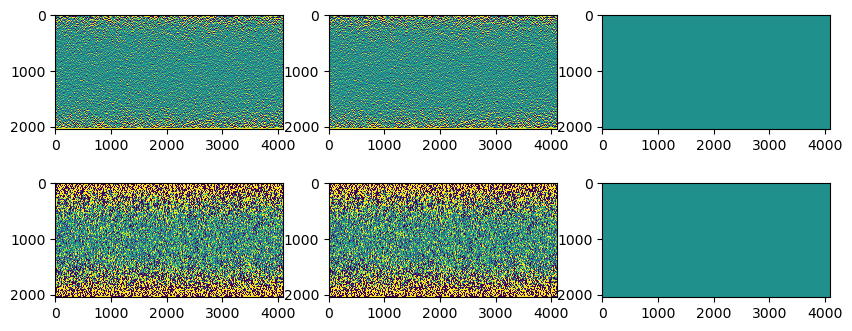

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(10,4))
ax[0,0].imshow(out_theta.get()[0].T, vmin=-1e4, vmax=1e4)
ax[0,1].imshow(grad_theta.T, vmin=-1e4, vmax=1e4)
ax[0,2].imshow((out_theta.get()[0]-grad_theta).T, vmin=-1e4, vmax=1e4)

ax[1,0].imshow(out_phi.get()[0].T, vmin=-1e4, vmax=1e4)
ax[1,1].imshow(grad_phi.T, vmin=-1e4, vmax=1e4)
ax[1,2].imshow((out_phi.get()[0]-grad_phi).T, vmin=-1e4, vmax=1e4)

In [14]:
test_cases = [ 
              (lmax, lmax) for lmax in [2**n-1 for n in np.arange(6, 8)]
              ]
for test_case in test_cases:
    cGPU = shtns.sht(int(test_case[0]), int(test_case[1]))
    cGPU.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS, nlat=int(test_case[0]+1), nphi=int(2*(test_case[1]+1)))
    alm_random = np.array([np.random.randn(cGPU.nlm).astype(complex)])
    alm = cp.array(alm_random, dtype=complex)
    print("Shape of alm: ", alm.shape)
    print("Shape of alm_random: ", alm_random.shape)
    
    synthesis_out = cp.empty((1,cGPU.nphi, cGPU.nlat), dtype=np.double)

    cGPU.cu_SH_to_spat(alm.data.ptr, synthesis_out.data.ptr)
    synth = cGPU.synth(alm_random)

  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
Shape of alm:  (1, 2080)
Shape of alm_random:  (1, 2080)
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
Shape of alm:  (1, 8256)
Shape of alm_random:  (1, 8256)


In [15]:
print("Shape of synthesis_out: ", synthesis_out.shape)
print("Shape of synth: ", synth.shape)

Shape of synthesis_out:  (1, 256, 128)
Shape of synth:  (256, 128)


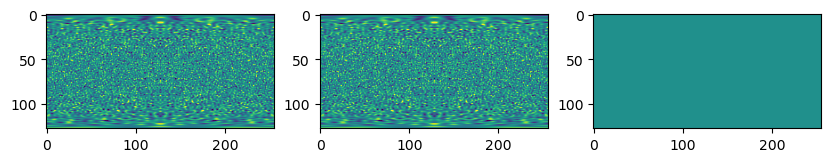

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].imshow(synth.T, vmin=-1e2, vmax=1e2)
ax[1].imshow(synthesis_out.get().T, vmin=-1e2, vmax=1e2)
ax[2].imshow(synthesis_out[0].get().T-synth.T, vmin=-1e2, vmax=1e2)